In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [2]:
df_countries = pd.read_csv('data/official_countries.csv')

In [3]:
df_japan = df_countries[df_countries['Country'] == 'Japan']

In [9]:
total_eq = len(df_countries)
total_jap_eq = len(df_japan)
tot_mag_mean = round(df_countries['Magnitude'].mean(),3)
mag_mean_jp = round(df_japan['Magnitude'].mean(),3)
japan_pct = round(total_jap_eq/total_eq,2)*100
print('Total:',total_eq,'Average Overall Mag:',tot_mag_mean)
print('Total Japan:',total_jap_eq,' Average Japan EQ Mag:',mag_mean_jp)
print('Japan %Total:',japan_pct,'%')

Total: 23229 Average Overall Mag: 5.883
Total Japan: 2102  Average Japan EQ Mag: 5.896
Japan %Total: 9.0 %


In [ ]:
stop

In [5]:
drop_extra=['Unnamed: 0']
df_japan = df_japan.reset_index(drop=True).drop(drop_extra,axis=1)

In [6]:
df_japan['Date_Time'] = pd.to_datetime(df_japan['Date_Time']).reset_index(drop=True)

In [7]:
japan_ts = pd.Series(df_japan.set_index(df_japan['Date_Time'])['Magnitude'])
mm_jp = japan_ts.resample('MS').mean()

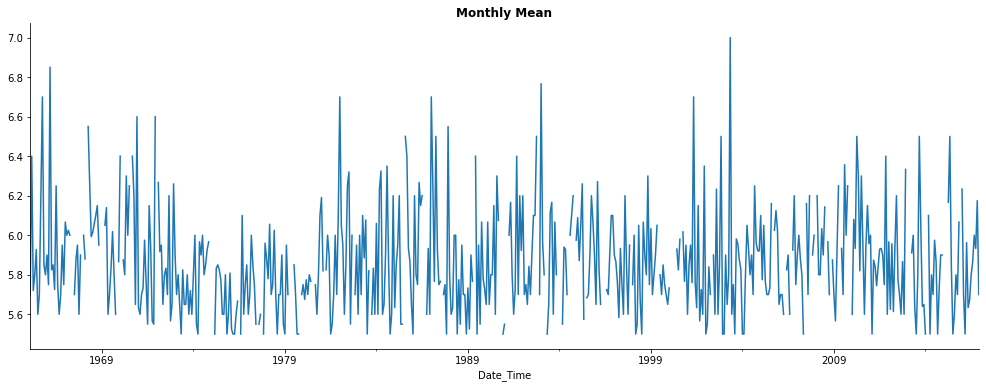

In [8]:
fig, ax = plt.subplots(figsize=(17,6))

mm_jp.plot()
ax.set_title('Monthly Mean', fontweight='bold')
sns.despine(top=True,right=True);

In [9]:
from statsmodels.tsa.stattools import adfuller

def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)
    print()
    if df_output['p-value'] < 0.05 and df_output['Test Statistic'] < -3.43: # -3.43 was the best I could find, on Wikipedia
        print('With ', len(ts), ' data points, a p-value of ', round(df_output['p-value'],7),'(<0.05) and a DFt of ',
              round(df_output['Test Statistic'],3),', the Null Hypothesis can be rejected and there appears to be stationarity.')
    elif df_output['p-value'] >= 0.05:
        print('p-value greater than 0.05:  ', df_output['p-value'])
    else:
        print('Failed to reject the Null Hypothesis and there appears to be a lack of stationarity.')

In [10]:
mm_jp_ff = mm_jp.ffill()

In [11]:
run_df(mm_jp_ff)

Dickey_Fuller test results:  

Test Statistic                 -21.104735
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64

With  623  data points, a p-value of  0.0 (<0.05) and a DFt of  -21.105 , the Null Hypothesis can be rejected and there appears to be stationarity.


498
125


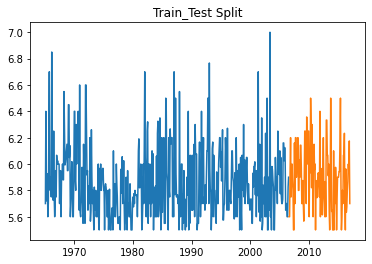

In [12]:
#Random Walk

cutoff = round(mm_jp_ff.shape[0] * 0.8)
train = mm_jp_ff[:cutoff]
test = mm_jp_ff[cutoff:]

print(len(train))
print(len(test))

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train_Test Split');

In [13]:
rw = train.shift(1)

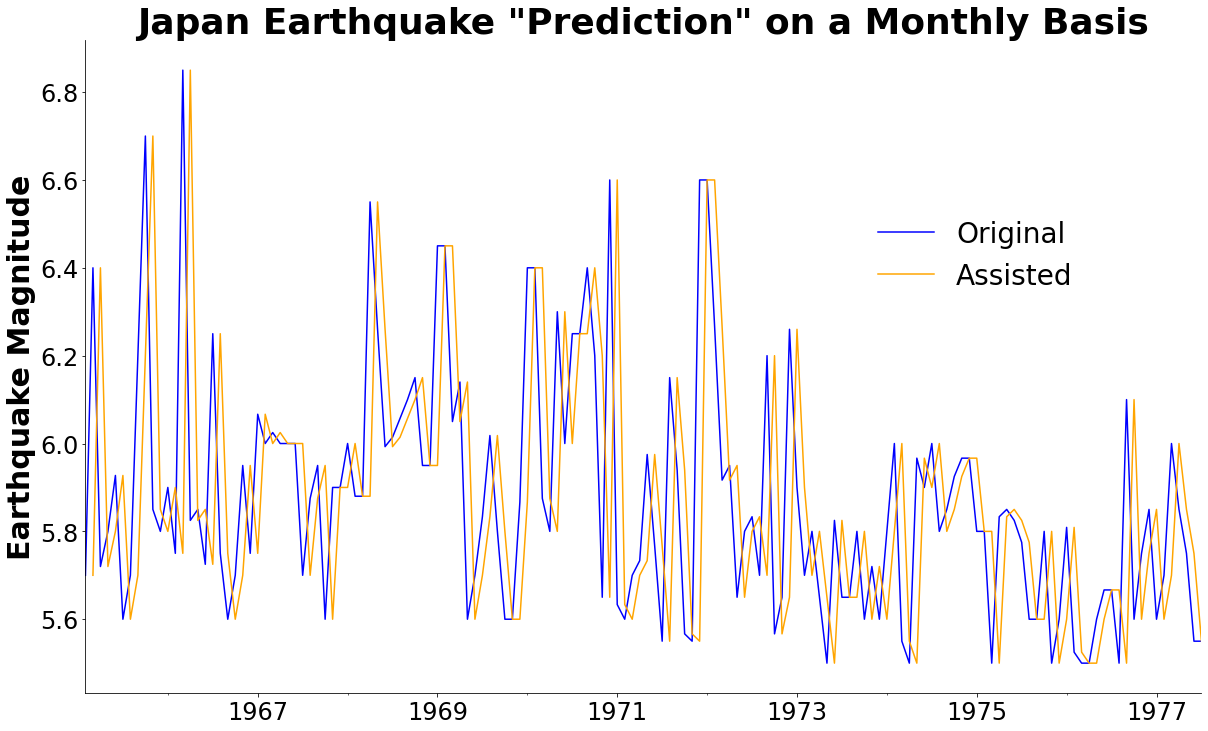

In [14]:
fig, ax = plt.subplots(figsize=(20,12))

train[0:150].plot(ax=ax, c='blue', label='Original')
rw[0:150].plot(ax=ax, c='orange', label='Assisted')
ax.set_title('Japan Earthquake "Prediction" on a Monthly Basis', fontsize=36, fontweight='bold')
sns.despine(right=True,top=True)
plt.ylabel('Earthquake Magnitude', fontsize=30, fontweight='bold')
plt.yticks(fontsize=24)
plt.xlabel('')
plt.xticks(fontsize=24)
ax.legend(fontsize=28,loc=(0.7,0.6), frameon=False);
# plt.savefig('images/random_walk_japan.png', dpi=300)

In [15]:
rw_rmse = np.sqrt(mean_squared_error(train.dropna()[1:], rw.dropna()))
rw_rmse

0.3459117063515684

In [16]:
residuals = rw[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

0.3459117063515684

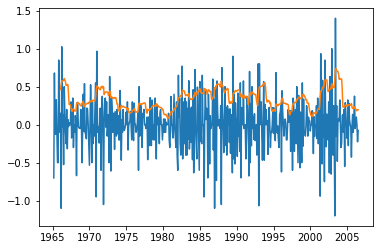

In [17]:
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(12).std());

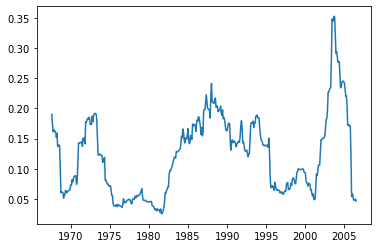

In [18]:
fig, ax=plt.subplots()
ax.plot(residuals.index, residuals.rolling(30).var());

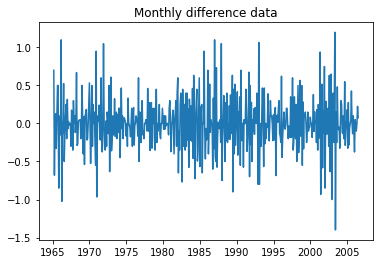

In [19]:
fig, ax=plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly difference data');

In [20]:
def get_yh(mod):
    return mod.predict(typ='levels')
def rmse(mod):
    return np.sqrt(mean_squared_error(train,mod))
def rmse_test(mod):
    return np.sqrt(mean_squared_error(test,mod))

In [21]:
rw = ARIMA(train, order=(0,1,0)).fit() # this overwrites the previous "rw"
y_hat_rw = get_yh(rw)
rw_rmse = rmse(y_hat_rw)
rw_rmse

0.4297157217807579

In [22]:
y_hat_test_rw = rw.predict(start=test.index[0],end=test.index[-1],typ='levels')
test_rw_rmse = rmse_test(y_hat_test_rw)
test_rw_rmse

0.2474066340675965

In [23]:
ar = ARIMA(train, order=(1,0,0)).fit()
y_hat_ar = get_yh(ar)
ar_rmse = rmse(y_hat_ar)
ar_rmse

0.26257811195562963

In [24]:
ari = ARIMA(train, order=(1,1,0)).fit()
y_hat_ari = get_yh(ari)
ari_rmse = rmse(y_hat_ari)
ari_rmse

0.40169100981161737

In [25]:
ma = ARIMA(train, order=(0,0,1)).fit()
y_hat_ma = get_yh(ma)
ma_rmse = rmse(y_hat_ma)
ma_rmse

0.26279170533661533

In [26]:
ima = ARIMA(train, order=(0,1,1)).fit()
y_hat_ima = get_yh(ima)
ima_rmse = rmse(y_hat_ima)
ima_rmse

0.3669297021429202

In [27]:
arima = ARIMA(train, order=(1,1,1)).fit()
y_hat_arima = get_yh(arima)
arima_rmse = rmse(y_hat_arima)
arima_rmse

0.3661455277111524

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


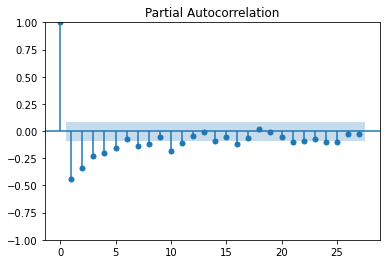

In [28]:
plot_pacf(train.diff().dropna());

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


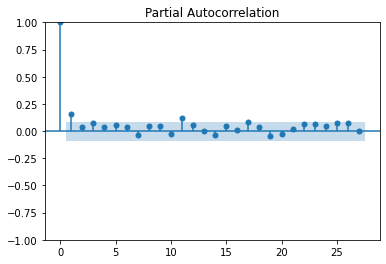

In [29]:
plot_pacf(train);

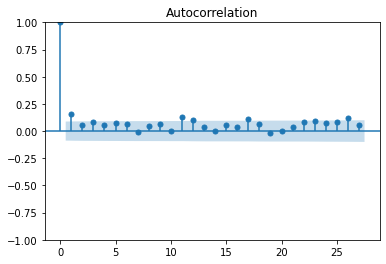

In [30]:
plot_acf(train);

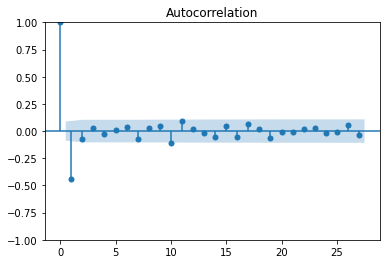

In [31]:
plot_acf(train.diff().dropna());

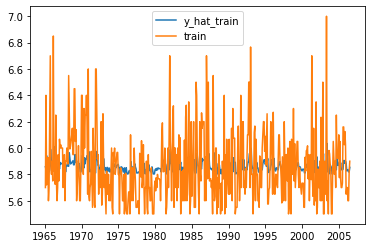

In [32]:
y_hat_train = y_hat_ar
fig, ax=plt.subplots()
ax.plot(y_hat_train)
ax.plot(train)
ax.legend(['y_hat_train','train']);

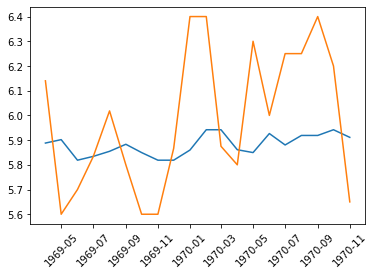

In [33]:
fig, ax=plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70])
plt.xticks(rotation=45);

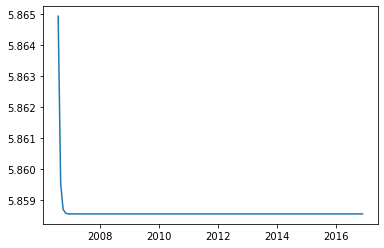

In [34]:
y_hat_test = ar.predict(start=test.index[0], end=test.index[-1],typ='levels')
fig, ax=plt.subplots()
ax.plot(y_hat_test);

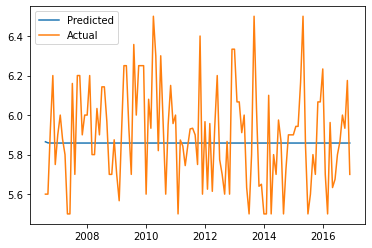

In [35]:
fig, ax=plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)
ax.legend(['Predicted','Actual']);

In [36]:
test_rmse = rmse_test(y_hat_test)
test_rmse

0.2508202934510924

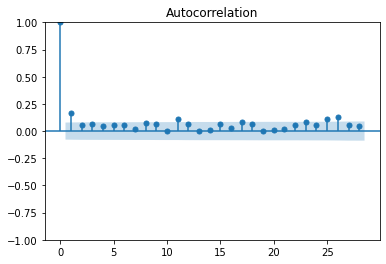

In [37]:
plot_acf(mm_jp_ff);

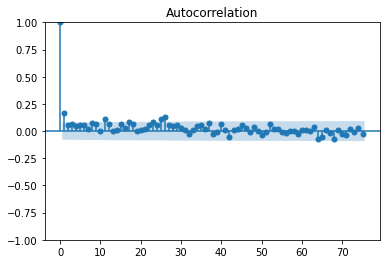

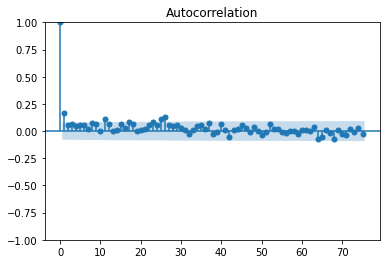

In [38]:
plot_acf(mm_jp_ff, lags=75)

In [39]:
# Only run once to optimize

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameters for SARIMA...')
for i in pdq:  ##  Only turn on when optimizing
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameters for SARIMA...
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 0, 2, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)
SARIMAX: (0, 0, 0) x (0, 1, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 2, 12)
SARIMAX: (0, 0, 0) x (0, 2, 0, 12)
SARIMAX: (0, 0, 0) x (0, 2, 1, 12)
SARIMAX: (0, 0, 0) x (0, 2, 2, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
SARIMAX: (0, 0, 0) x (1, 0, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 2, 12)
SARIMAX: (0, 0, 0) x (1, 1, 0, 12)
SARIMAX: (0, 0, 0) x (1, 1, 1, 12)
SARIMAX: (0, 0, 0) x (1, 1, 2, 12)
SARIMAX: (0, 0, 0) x (1, 2, 0, 12)
SARIMAX: (0, 0, 0) x (1, 2, 1, 12)
SARIMAX: (0, 0, 0) x (1, 2, 2, 12)
SARIMAX: (0, 0, 0) x (2, 0, 0, 12)
SARIMAX: (0, 0, 0) x (2, 0, 1, 12)
SARIMAX: (0, 0, 0) x (2, 0, 2, 12)
SARIMAX: (0, 0, 0) x (2, 1, 0, 12)
SARIMAX: (0, 0, 0) x (2, 1, 1, 12)
SARIMAX: (0, 0, 0) x (2, 1, 2, 12)
SARIMAX: (0, 0, 0) x (2, 2, 0, 12)
SARIMAX: (0, 0, 0) x (2, 2, 1, 12)
SARIMAX: (0, 0, 0) x (2, 2, 2, 12)
SARIMAX: (0, 0, 1)

In [40]:
# # Only run once to find optimized parameters

# SARIMAX_dict1 = {'stats':[],'aic':[]} # Dictionary mackes it easy to look through results when finished
# for param in pdq:  # Only run again if we need to re-optimize
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod=SARIMAX(train,
#                          order=param,
#                          seasonal_order=param_seasonal,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#             results = mod.fit()
#             SARIMAX_dict1['stats'].append('ARIMA{}x{}'.format(param,param_seasonal))
#             SARIMAX_dict1['aic'].append(results.aic)
#             print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             print('Oops!')
#             continue
# df_sar = pd.DataFrame(SARIMAX_dict1)
# df_sar.to_csv('data/SARIMAX_jap_dict1.csv')

In [41]:
df_sarima = pd.read_csv('data/SARIMAX_jap_dict1.csv')
df_sarima.sort_values('aic').head(20)

,Unnamed: 0,stats,aic
136,136,"ARIMA(0, 1, 2)x(0, 0, 1, 12)",64.918499
379,379,"ARIMA(1, 1, 2)x(0, 0, 1, 12)",65.967387
622,622,"ARIMA(2, 1, 2)x(0, 0, 1, 12)",66.247930
145,145,"ARIMA(0, 1, 2)x(1, 0, 1, 12)",66.692638
603,603,"ARIMA(2, 1, 1)x(1, 0, 0, 12)",66.756947
388,388,"ARIMA(1, 1, 2)x(1, 0, 1, 12)",67.556204
352,352,"ARIMA(1, 1, 1)x(0, 0, 1, 12)",67.788912
631,631,"ARIMA(2, 1, 2)x(1, 0, 1, 12)",67.898274
153,153,"ARIMA(0, 1, 2)x(2, 0, 0, 12)",68.307643
541,541,"ARIMA(2, 0, 2)x(0, 0, 1, 12)",68.600524


(0,1,2),(0,0,1,12) RMSE:
train:   0.37178119314929875
test:  0.2524374557881694


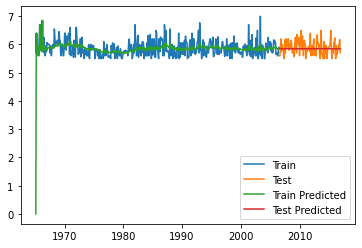

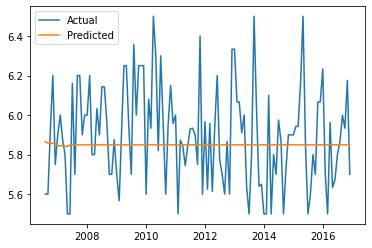

In [42]:
sari_mod =SARIMAX(train,
                  order=(0,1,2),
                  seasonal_order=(0, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_012001_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_012001_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(0,1,2),(0,0,1,12) RMSE:')
print('train:  ',rmse_012001_train)
print('test: ',rmse_012001_test)

fig, ax = plt.subplots()
ax.plot(train, label='Train')
ax.plot(test, label='Test')
ax.plot(y_hat_train, label='Train Predicted')
ax.plot(y_hat_test, label='Test Predicted')

plt.legend();

fig, ax = plt.subplots()

ax.plot(test, label='Actual')
ax.plot(y_hat_test, label='Predicted')

plt.legend();

In [43]:
sari_mod =SARIMAX(train,
                  order=(1,1,2),
                  seasonal_order=(0, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_112001_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_112001_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(1,1,2),(0,0,1,12) RMSE:')
print('train:  ',rmse_112001_train)
print('test: ',rmse_112001_test)

sari_mod =SARIMAX(train,
                  order=(2,1,2),
                  seasonal_order=(0, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_212001_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_212001_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(2,1,2),(0,0,1,12) RMSE:')
print('train:  ',rmse_212001_train)
print('test: ',rmse_212001_test)

sari_mod =SARIMAX(train,
                  order=(0,1,2),
                  seasonal_order=(1, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_012101_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_012101_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(0,1,2),(1,0,1,12) RMSE:')
print('train:  ',rmse_012101_train)
print('test: ',rmse_012101_test)

sari_mod =SARIMAX(train,
                  order=(2,1,1),
                  seasonal_order=(1, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_211100_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_211100_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(2,1,1),(1,0,0,12) RMSE:')
print('train:  ',rmse_211100_train)
print('test: ',rmse_211100_test)

sari_mod =SARIMAX(train,
                  order=(1,1,2),
                  seasonal_order=(1, 0, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')
rmse_112101_train = np.sqrt(mean_squared_error(train,y_hat_train))
rmse_112101_test = np.sqrt(mean_squared_error(test,y_hat_test))
print('(1,1,2),(1,0,1,12) RMSE:')
print('train:  ',rmse_112101_train)
print('test: ',rmse_112101_test)


(1,1,2),(0,0,1,12) RMSE:
train:   0.381360730017701
test:  0.25259642643893254
(2,1,2),(0,0,1,12) RMSE:
train:   0.3865716188812303
test:  0.2524222623795004
(0,1,2),(1,0,1,12) RMSE:
train:   0.372260212508774
test:  0.2524585628615527
(2,1,1),(1,0,0,12) RMSE:
train:   0.37185179077617686
test:  0.2524521748483928
(1,1,2),(1,0,1,12) RMSE:
train:   0.38268851017884853
test:  0.25262379565368137


In [44]:
df_mm_jp_ff = pd.read_csv('data/RMSE_Tracking_Jap_MM_FFill.csv')

In [45]:
df_mm_jp_ff.head(20)

,Type,"p,d,q","P,D,Q",RMSE-Tr,RMSE-Te,AIC,Unnamed: 6
0,MM Jap FillF Random Walk,"0,1,0","0,0,0",0.4297,0.2474,353.0,NaN
1,MM Jap FillF,"1,0,0","0,0,0",0.2626,0.2508,358.0,NaN
2,MM Jap FillF,"1,1,0","0,0,0",0.4017,NAN,247.0,NaN
3,MM Jap FillF,"0,0,1","0,0,0",0.2628,NAN,2523.3,NaN
4,MM Jap FillF,"0,1,1","0,0,0",0.3669,NAN,82.7,NaN
5,MM Jap FillF,"1,1,1","0,0,0",0.3661,NAN,80.1,NaN
6,MM Jap FillF,"0,1,2","0,0,1",0.3718,0.2524,64.9,NaN
7,MM Jap FillF,"1,1,2","0,0,1",0.3814,0.2526,66.0,NaN
8,MM Jap FillF,"2,1,2","0,0,1",0.3866,0.2524,66.2,NaN
9,MM Jap FillF,"0,1,2","1,0,1",0.3723,0.2525,66.7,NaN


Best Model is (0,1,2),(0,0,1,12) with Train RMSE 0.3718, Test RMSE 0.2524 and Lowest AIC of all at 64.9

In [46]:
sari_mod = SARIMAX(mm_jp_ff,
                  order=(0,1,2),
                  seasonal_order=(0,0,1,12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [47]:
forecast = sari_mod.forecast(steps=24)

Text(0.5, 1.0, 'Earthquakes in Japan Predictions\n Two Years Out')

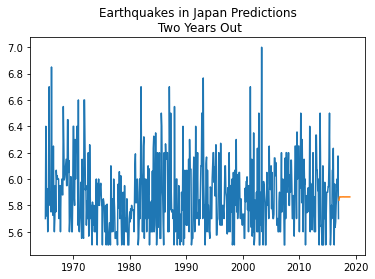

In [48]:
fig, ax = plt.subplots()

ax.plot(mm_jp_ff, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('Earthquakes in Japan Predictions\n Two Years Out')

## Trying a SARIMAX to hopefully introduce Lat/Long/Depth into the mix, rather than just Magnitude

In [49]:
# Setting up the different Series
monthly_lat_jp = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Latitude'])).resample('MS').mean()
monthly_long_jp = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Longitude'])).resample('MS').mean()
monthly_dep_jp = (pd.Series(df_japan.set_index(df_japan['Date_Time'])['Depth'])).resample('MS').mean()

In [50]:
monthly_lat_jp_nona = monthly_lat_jp.ffill()
monthly_long_jp_nona = monthly_long_jp.ffill()
monthly_dep_jp_nona = monthly_dep_jp.ffill()

In [51]:
# Endogenous and Exogenous Variables:
endo = mm_jp_ff # Magnitude
exo_lat = monthly_lat_jp_nona
exo_long = monthly_long_jp_nona
exo_dep = monthly_dep_jp_nona

New Train/Test Split?

Lat/Long Array for more precise location testing

In [52]:
lat_long_array = np.array([[exo_lat][0], [exo_long][0]]).transpose()

In [53]:
# Fitting the models

mod_lat = SARIMAX(endo, exo_lat,
                 order=(0,1,2,),
                 seasonal_order=(0,0,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_long = SARIMAX(endo, exo_long,
                 order=(0,1,2,),
                 seasonal_order=(0,0,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_dep = SARIMAX(endo, exo_dep,
                 order=(0,1,2,),
                 seasonal_order=(0,0,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_lat_long = SARIMAX(exo_lat, exo_long, # exo_lat is the "endo" for this model
                 order=(0,1,2,),
                 seasonal_order=(0,0,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()

mod_mag_lat_long = SARIMAX(endo, lat_long_array,
                 order=(0,1,2,),
                 seasonal_order=(0,0,1,12),
                 enforce_stationarity=False,
                 enforce_invertibility=False).fit()


In [54]:
mod_list = [mod_lat,mod_long,mod_dep,mod_lat_long,mod_mag_lat_long]

In [55]:
for model in mod_list:
    print(model.summary())
    y_hat_train = model.predict(typ='levels')
    y_hat_train = y_hat_train[:cutoff]
#     print(y_hat_train)
    y_hat_test = model.predict(start=test.index[0], end=test.index[-1], typ='levels')
#     print(y_hat_test)
    rmse_train = np.sqrt(mean_squared_error(train,y_hat_train))
    rmse_test = np.sqrt(mean_squared_error(test,y_hat_test))
    print('train: ', rmse_train)
    print('test: ', rmse_test)
    print()

                                      SARIMAX Results                                       
Dep. Variable:                            Magnitude   No. Observations:                  623
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood                 -30.926
Date:                              Thu, 02 Dec 2021   AIC                             71.853
Time:                                      21:56:00   BIC                             93.895
Sample:                                  02-01-1965   HQIC                            80.429
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Latitude       0.0010      0.002      0.547      0.584      -0.003       0.005
ma.L1         -0.83